In [1]:
!pip install albumentations > /dev/null
!git clone https://github.com/qubvel/efficientnet.git
!pip install console_progressbar

Cloning into 'efficientnet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 310 (delta 1), reused 0 (delta 0), pack-reused 305
Receiving objects: 100% (310/310), 835.11 KiB | 14.91 MiB/s, done.
Resolving deltas: 100% (175/175), done.
  Preparing metadata (setup.py) ... - done
  Created wheel for console-progressbar: filename=console_progressbar-1.1.2-py3-none-any.whl size=4157 sha256=ff91696441917d4ab31097436fa021f250b0ae7172d93c23d87497b397b9f2bf
  Stored in directory: /root/.cache/pip/wheels/2b/5f/7d/97976c8b046302df5781c0cbb18fd04b9d58467edae9942bfa
Successfully built console-progressbar


In [2]:
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar

In [3]:
img_width, img_height = 299, 299

def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
cars_meta = scipy.io.loadmat('../input/matfile/devkit/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]


In [5]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
from PIL import Image
import cv2

from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers.pooling import MaxPooling2D,AveragePooling2D

In [6]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'][1:])
    plt.plot(history.history['val_accuracy'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [7]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
#             callbacks.ModelCheckpoint("./keras.model",monitor='val_loss', 
#                                    mode = 'min', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

import keras.callbacks as callbacks

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../input/aiproject/train/train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '../input/aiproject/valid/valid',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 7804 images belonging to 196 classes.
Found 2918 images belonging to 196 classes.


In [9]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, num_classes):

    x = base_model.output
    
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
#     x = Dropout(0.25)(x)
#     x = Dense(512,activation='relu')(x)
    x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [10]:
HEIGHT = 299
WIDTH = 299

input_shape=(HEIGHT, WIDTH, 3)

FC_LAYERS = [1024]
dropout = 0.7
epochs = 81
swa = SWA('./keras_swa.model',epochs-3)

base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(HEIGHT, WIDTH, 3))

model = build_finetune_model(base_model, dropout=dropout, num_classes=196)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)

history = model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=205,epochs=epochs,verbose=1,validation_steps=52,callbacks=snapshot.get_callbacks())

try:
    model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)

2022-01-04 16:17:12.257103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 16:17:12.348173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 16:17:12.348919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 16:17:12.350103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/81


2022-01-04 16:17:17.449795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-04 16:17:26.250729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


205/205 [==============================] - 227s 1s/step - loss: 5.3593 - accuracy: 0.0133 - val_loss: 5.6201 - val_accuracy: 0.0060
Epoch 2/81
205/205 [==============================] - 199s 970ms/step - loss: 4.5697 - accuracy: 0.0689 - val_loss: 6.3105 - val_accuracy: 0.0048
Epoch 3/81
205/205 [==============================] - 202s 985ms/step - loss: 3.5280 - accuracy: 0.1882 - val_loss: 4.6624 - val_accuracy: 0.0745
Epoch 4/81
205/205 [==============================] - 203s 989ms/step - loss: 2.6239 - accuracy: 0.3350 - val_loss: 6.2916 - val_accuracy: 0.0048
Epoch 5/81
205/205 [==============================] - 201s 980ms/step - loss: 1.9563 - accuracy: 0.4738 - val_loss: 5.9550 - val_accuracy: 0.0042
Epoch 6/81
205/205 [==============================] - 206s 1s/step - loss: 1.5301 - accuracy: 0.5828 - val_loss: 6.0988 - val_accuracy: 0.0024
Epoch 7/81
205/205 [==============================] - 204s 993ms/step - loss: 1.2337 - accuracy: 0.6498 - val_loss: 5.9701 - val_accuracy: 0.

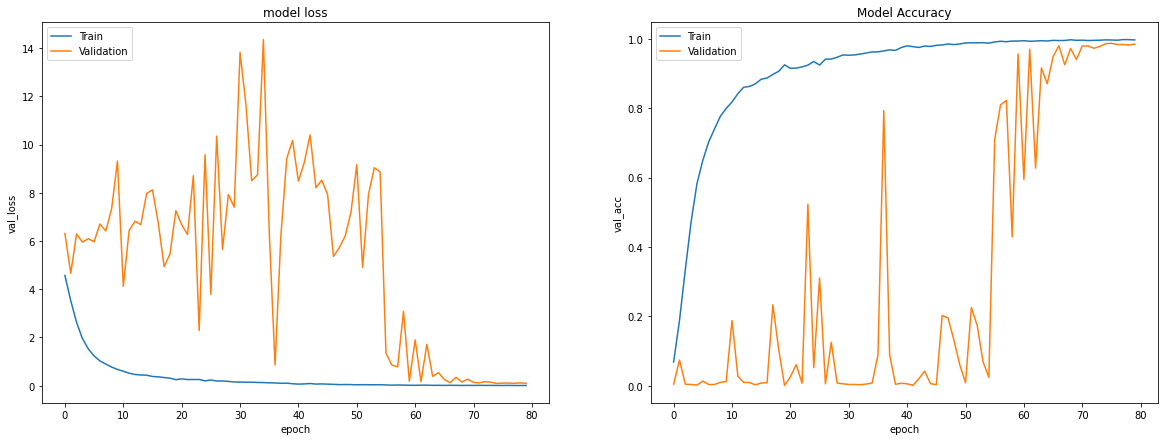

In [11]:
plot_loss_acc(history)

In [12]:
from tqdm import tqdm_notebook
import scipy.io as sio

num_samples,all_preds = 8041,[]
out = open('result.txt','a')
for i in tqdm_notebook(range(num_samples)):
    filename = os.path.join('../input/testdata/cars_test', '%05d.jpg' % (i + 1))
    bgr_img = cv.imread(filename)
    rgb_img = cv.resize(cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)/255,(299,299))
    rgb_img = np.expand_dims(rgb_img, 0)
    preds = model.predict(rgb_img)
    class_id = np.argmax(preds)
    all_preds.append(class_id)
    out.write('{}\n'.format(str(class_id + 1)))
    
out.close()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8041 [00:00<?, ?it/s]

In [13]:
labels = sio.loadmat('../input/matfile/devkit/cars_test_annos_withlabels.mat')
actual_preds = np.array(labels['annotations']['class'],dtype=np.int)-1;
actual_preds = actual_preds.squeeze()
all_preds = np.array(all_preds)

In [14]:
print('accuracy = ',(all_preds==actual_preds).sum()/len(actual_preds))

accuracy =  0.8883223479666709
